In [1]:
import pandas as pd
import os

# Specify the directory containing the pickle files
directory = '../ressources/final_experiments/result_guided_exp'

# Initialize a list or dictionary to hold the DataFrames
dataframes = {}

# Iterate through the files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.pickle'):  # Check for pickle files
        file_path = os.path.join(directory, filename)  # Create full file path
        df = pd.read_pickle(file_path)  # Load the DataFrame from the pickle file
        dataframes[filename] = df  # Store the DataFrame in the dictionary

dataframes.keys()


dict_keys(['llm_evaluated_uniform.pickle', 'llm_evaluated_targeted.pickle', 'llm_evaluated_control_mixed_samesize.pickle'])

In [2]:
list(dataframes.values())[0].head(3)

,index,description,configuration,parameters,argos,behavior_tree,scores,avg_score,type,lightstype,arenatype,robotstype,llm_scores,llm_behavior_tree,llm_avg_score
0,0,The environment is a circular arena with radiu...,"<?xml version=""1.00"" ?>\n<config>\n <swarm-el...",MissionParams(arena_params=CircularArena(radiu...,"<?xml version=""1.00"" ?>\n<argos-configuration>...",--nroot 3 --nchildroot 4 --n0 0 --nchild0 2 --...,"[4.0, 2.0, 4.0, 5.0, 3.0, 4.0, 1.0, 3.0, 5.0, ...",3.600000,Foraging,TargetLights,CircularArena,CenteredSwarm,"[3.0, 3.0, 4.0, 0.0, 3.0, 2.0, 6.0, 0.0, 0.0, ...",--nroot 3 --nchildroot 3 --n0 0 --nchild0 2 -...,2.400000
1,1,The environment consists of a circular arena w...,"<?xml version=""1.00"" ?>\n<config>\n <swarm-el...",MissionParams(arena_params=CircularArena(radiu...,"<?xml version=""1.00"" ?>\n<argos-configuration>...",--nroot 3 --nchildroot 1 --n0 0 --nchild0 2 --...,"[3.0, 3.0, 4.0, 2.0, 1.0, 2.0, 5.0, 3.0, 4.0, ...",2.900000,Foraging,UniformLights,CircularArena,CenteredSwarm,[],--nroot 3 --nchildroot 2 --nroot0 0 --nchildr...,NaN
2,2,"With a radius of 3.44 meters, the circular are...","<?xml version=""1.00"" ?>\n<config>\n <swarm-el...",MissionParams(arena_params=CircularArena(radiu...,"<?xml version=""1.00"" ?>\n<argos-configuration>...",--nroot 3 --nchildroot 3 --n0 0 --nchild0 2 --...,"[-8.57746, -4.79552, -7.16427, -9.41532, -6.30...",-7.018138,Connection,UniformLights,CircularArena,CenteredSwarm,"[-6.93895, -8.89168, -7.16934, -7.99283, -8.84...",--nroot 3 --nchildroot 2 --n0 0 --nchild0 2 -...,-7.854127


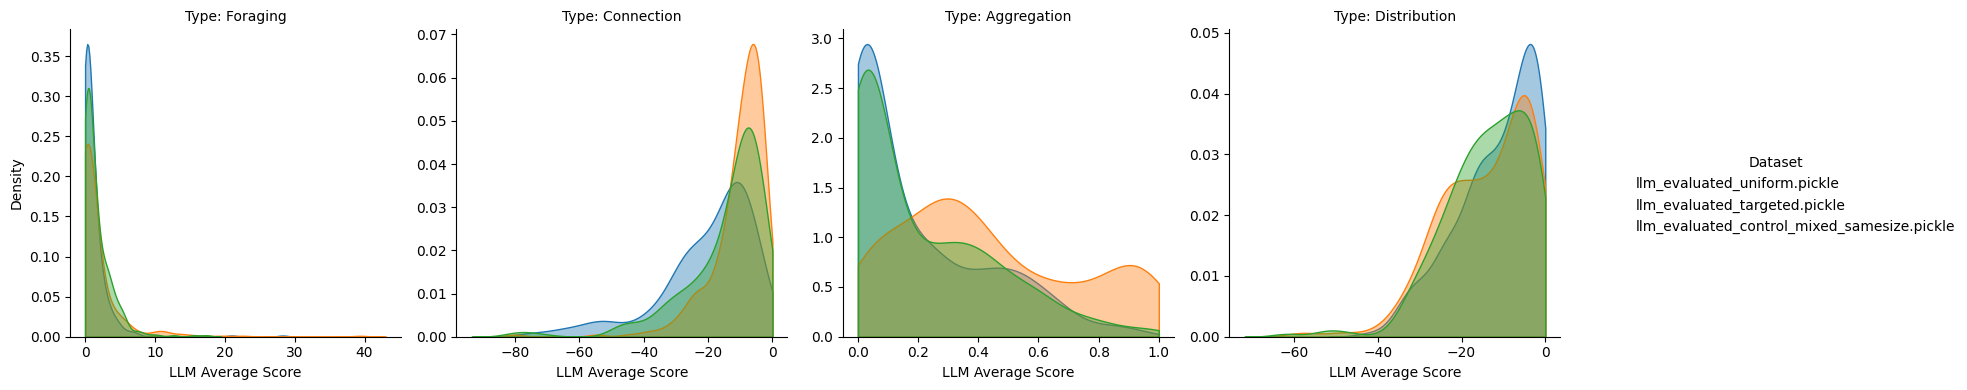

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine data from all three dataframes into one
df_list = []
for name, df in dataframes.items():
    temp_df = df[['type', 'llm_avg_score']].copy()
    temp_df['Dataset'] = name  # Add a column to indicate the dataset
    df_list.append(temp_df)

df_combined = pd.concat(df_list, ignore_index=True)

# Define clipping for specific types
clip_limits = {
    "Foraging": (0, None),       # 0 to ∞
    "Aggregation": (0, 1),       # 0 to 1
    "Distribution": (None, 0),   # -∞ to 0
    "Connection": (None, 0)      # -∞ to 0
}

# Create the FacetGrid
g = sns.FacetGrid(df_combined, col='type', hue='Dataset', height=4, aspect=1, sharex=False, sharey=False)

# Apply kdeplot to each facet with appropriate clipping
for type_name, ax in zip(g.col_names, g.axes.flat):
    subset = df_combined[df_combined["type"] == type_name]  # Select relevant data
    clip_range = clip_limits.get(type_name, (0, None))  # Get appropriate clipping limits
    
    # Plot all datasets in the same facet
    for dataset in subset["Dataset"].unique():
        sns.kdeplot(data=subset[subset["Dataset"] == dataset], x='llm_avg_score', 
                    fill=True, alpha=0.4, clip=clip_range, ax=ax, label=dataset)

g.set_titles(col_template='Type: {col_name}')
g.set_axis_labels('LLM Average Score', 'Density')

# Add a legend
g.add_legend(title='Dataset')

# Show the plot
g.tight_layout()
plt.show()


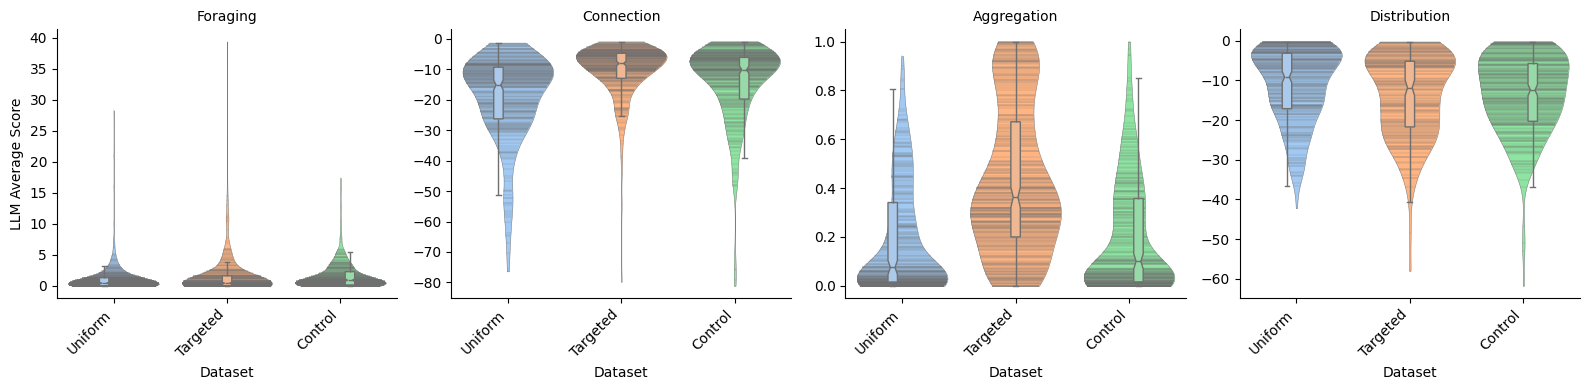

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the FacetGrid with violin plots
g = sns.FacetGrid(df_combined, col='type', height=4, aspect=1, sharex=True, sharey=False)

# Violin plot with one side and density normalization
g.map_dataframe(sns.violinplot, x='Dataset', y='llm_avg_score', hue='Dataset', 
                split=False, inner='stick', density_norm='area', 
                palette="pastel", cut=0, dodge=False, native_scale=True, legend="auto", 
                saturation=1.0, linewidth=0.33,width=0.25)

# Overlay notched boxplots
g.map_dataframe(sns.boxplot, x='Dataset', y='llm_avg_score', hue='Dataset', 
                dodge=False, width=0.25, palette="pastel", 
                fliersize=0, notch=True, linewidth=1.0)

# Set titles and labels
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Dataset', 'LLM Average Score')

# Rename x-axis labels to shorter names
label_mapping = {
    'llm_evaluated_uniform.pickle': 'Uniform',
    'llm_evaluated_targeted.pickle': 'Targeted',
    'llm_evaluated_control_mixed_samesize.pickle': 'Control'
}

# Manually replace the Dataset values in the plot
for ax in g.axes.flat:
    # Get the current x-ticks
    current_ticks = ax.get_xticks()
    
    # Explicitly set the new tick labels and positions
    new_labels = [label_mapping.get(df_combined['Dataset'].unique()[int(tick)], 'Unknown') for tick in current_ticks]
    ax.set_xticks(current_ticks)  # Ensure the ticks are set first
    ax.set_xticklabels(new_labels, rotation=45, ha='right')

# Set log scale for the y-axis of the first facet (e.g., for the first facet in the first row)
#g.axes[0, 0].set_yscale('log')  # Set log scale for the y-axis of the first facet

# Show the plot
g.tight_layout()
plt.show()


In [28]:
# Calculate min, mean, and max of 'llm_avg_score' grouped by 'type' and 'Dataset'
summary_stats = df_combined.groupby(['type', 'Dataset'])['llm_avg_score'].agg(['min', 'mean', 'max']).reset_index()

# Pivot the table to have 'Dataset' on the rows and 'type' on the columns
pivot_table = summary_stats.pivot_table(index='Dataset', columns='type', values=['min', 'mean', 'max'])

# Display the pivot table
pivot_table



max             \
type                                        Aggregation Connection   
Dataset                                                              
llm_evaluated_control_mixed_samesize.pickle        1.00  -0.976225   
llm_evaluated_targeted.pickle                      1.00  -1.183899   
llm_evaluated_uniform.pickle                       0.94  -1.535742   

                                                                         mean  \
type                                        Distribution Foraging Aggregation   
Dataset                                                                         
llm_evaluated_control_mixed_samesize.pickle    -0.196182     17.4    0.210085   
llm_evaluated_targeted.pickle                  -0.298293     39.4    0.430765   
llm_evaluated_uniform.pickle                   -0.177415     28.3    0.194916   

                                                                               \
type                                        Connection Distribution  Foraging   
Dataset                                                                         
llm_evaluated_control_mixed_samesize.pickle -14.595627   -13.829097  1.638562   
llm_evaluated_targeted.pickle               -10.513657   -14.065830  1.708904   
llm_evaluated_uniform.pickle                -20.039963   -11.501501  1.144986   

                                                    min             \
type                                        Aggregation Connection   
Dataset                                                              
llm_evaluated_control_mixed_samesize.pickle         0.0  -81.06880   
llm_evaluated_targeted.pickle                       0.0  -79.77544   
llm_evaluated_uniform.pickle                        0.0  -76.33872   

                                                                   
type                                        Distribution Foraging  
Dataset                                                            
llm_evaluated_control_mixed_samesize.pickle    -61.78522      0.0  
llm_evaluated_targeted.pickle                  -58.00945      0.0  
llm_evaluated_uniform.pickle                   -42.19048      0.0